In [1]:
import pandas as pd
import os
import requests
import json
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

In [3]:
from preprocessing_utils import preprocess_NVD_data

In [4]:
data_path = 'data'
if not os.path.exists(data_path):
    os.makedirs(data_path)

# EPSS data

Download the EPSS data from https://www.first.org/epss/data_stats into `data` folder

### <font color='blue'><b><i>TODO</i></b></font>:
- in the following cell, replace `epss_scores-2025-09-30.csv.gz` with the correct updated file (`epss_scores-2025-10-01.csv.gz`)

In [ ]:
epss_current = pd.read_csv(os.path.join(data_path, 'epss_scores-2025-10-01.csv.gz'), compression='gzip', header=1)
epss_current # a Python statement with a variable name at the end of a cell will display its contents below


,cve,epss,percentile
0,CVE-1999-0001,0.01076,0.76989
1,CVE-1999-0002,0.15339,0.94299
2,CVE-1999-0003,0.90362,0.99579
3,CVE-1999-0004,0.03215,0.86476
4,CVE-1999-0005,0.25334,0.95924
...,...,...,...
297261,CVE-2025-9994,0.00063,0.19981
297262,CVE-2025-9996,0.00179,0.39874
297263,CVE-2025-9997,0.00182,0.40233
297264,CVE-2025-9998,0.00025,0.05529


# NVD data

In [20]:
base_url = "https://services.nvd.nist.gov/rest/json/cves/2.0"
date_start_NVD = '2025-09-01T00:00:00.000Z' # Do NOT change these dates
date_end_NVD   = '2025-10-01T00:00:00.000Z' # Do NOT change these dates
start_index = 0
results_per_page = 1000
total_results = 1 

all_cves = []

while start_index < total_results:
    params = {
        "pubStartDate": date_start_NVD,
        "pubEndDate": date_end_NVD,
        "resultsPerPage": results_per_page,
        "startIndex": start_index,
        "noRejected": ""
    }
    response = requests.get(base_url, params=params, timeout=6)
    if response.status_code != 200:
        print("Error:", response.status_code)
        break

    data = response.json()
    total_results = data.get("totalResults", 0)

    all_cves.extend(data.get("vulnerabilities", []))

    start_index += results_per_page
    print(start_index)

1000
2000
3000
4000
5000


In [21]:
# normalize and preprocess data
df = pd.json_normalize(all_cves, record_path=None, sep='.', max_level=None)
df = preprocess_NVD_data(df)

# remove vulnerabilities marked as "reject" or "reserved"
df = df[(df['cve.vulnStatus']!='Reserved') & (df['cve.vulnStatus']!='Reject')]

# merge NVD and EPSS data
df = df.merge(epss_current, left_on="cve.id", right_on="cve", how="left")

In [22]:
# save nvd data
with open(os.path.join(data_path, "nvd_cves.json"), "w", encoding="utf-8") as f:
    json.dump(all_cves, f, indent=2)
    
# save the final dataframe
df.to_csv(os.path.join(data_path, "vuln_2025_09.csv"))

# Exploratory Data Analysis

- display some examples (e.g., the first two CVE records)

In [9]:
df.head(2).T

,0,1
cve.id,CVE-2025-9751,CVE-2025-9752
cve.sourceIdentifier,cna@vuldb.com,cna@vuldb.com
cve.published,2025-09-01 00:15:34.580000,2025-09-01 01:15:46.817000
cve.lastModified,2025-09-08 14:06:05.217000,2025-09-04 18:47:25.440000
cve.vulnStatus,Analyzed,Analyzed
cve.references,[{'url': 'https://github.com/HAO-RAY/HCR-CVE/i...,[{'url': 'https://github.com/i-Corner/cve/issu...
cve.cisaExploitAdd,NaN,NaN
cve.cisaActionDue,NaN,NaN
cve.cisaRequiredAction,NaN,NaN
cve.cisaVulnerabilityName,NaN,NaN


- show a bar plot with the daily volume of published CVEs

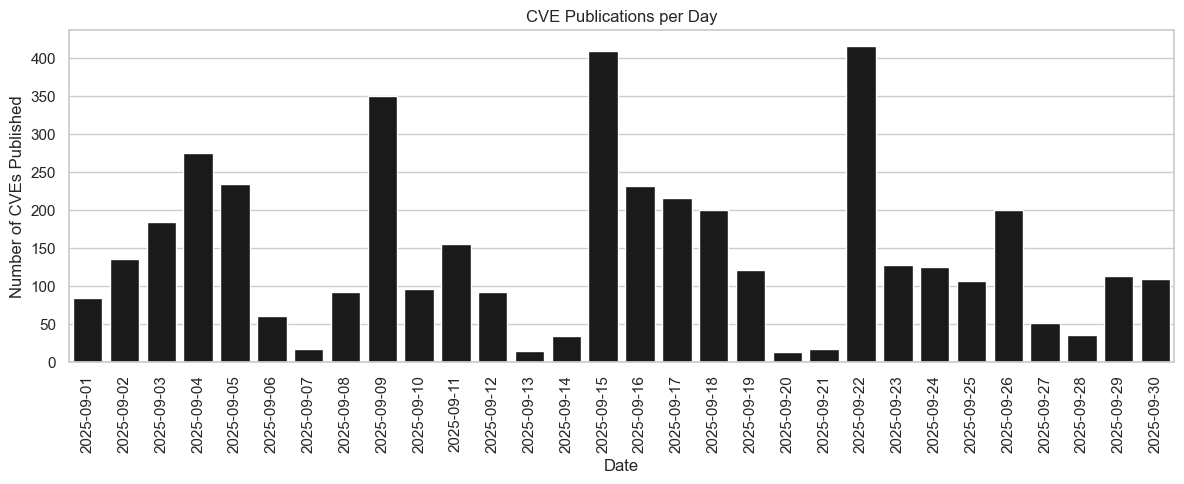

In [10]:
published_counts = df["cve.published"].dt.date.value_counts().sort_index()

plt.figure(figsize=(12, 5))
sns.barplot(x=published_counts.index, y=published_counts.values, color="k" )
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Number of CVEs Published")
plt.title("CVE Publications per Day")
plt.tight_layout()
plt.show()

In [11]:
df.head(2).T

,0,1
cve.id,CVE-2025-9751,CVE-2025-9752
cve.sourceIdentifier,cna@vuldb.com,cna@vuldb.com
cve.published,2025-09-01 00:15:34.580000,2025-09-01 01:15:46.817000
cve.lastModified,2025-09-08 14:06:05.217000,2025-09-04 18:47:25.440000
cve.vulnStatus,Analyzed,Analyzed
cve.references,[{'url': 'https://github.com/HAO-RAY/HCR-CVE/i...,[{'url': 'https://github.com/i-Corner/cve/issu...
cve.cisaExploitAdd,NaN,NaN
cve.cisaActionDue,NaN,NaN
cve.cisaRequiredAction,NaN,NaN
cve.cisaVulnerabilityName,NaN,NaN


- print the description of the last ten published vulnerabilities

In [12]:
for idx, x in enumerate(df.sort_values('cve.published', ascending=False)[:10].iterrows()):
    print('-'*100)
    print(x[1]['cve.id'], x[1]['cve.published'])
    print(x[1].description)


----------------------------------------------------------------------------------------------------
CVE-2025-61792 2025-09-30 23:15:29.700000
Quadient DS-700 iQ devices through 2025-09-30 might have a race condition during the quick clicking of (in order) the Question Mark button, the Help Button, the About button, and the Help Button, leading to a transition out of kiosk mode into local administrative access. NOTE: the reporter indicates that the "behavior was observed sporadically" during "limited time on the client site," making it not "possible to gain more information about the specific kiosk mode crashing issue," and the only conclusion was "there appears to be some form of race condition." Accordingly, there can be doubt that a reproducible cybersecurity vulnerability was identified; sporadic software crashes can also be caused by a hardware fault on a single device (for example, transient RAM errors). The reporter also describes a variety of other issues, including initial acc

### <font color='blue'><b><i>TODO</i></b>: produce plots or tables to address the folowing points</font>
- what is the percentage of CVEs which received a CVSS score?
- report descriptive statistics of CVSS the CVSS base score and/or show its distribution
- report descriptive statistics of EPSS and/or show its distribution
- produce a scatter plot showing CVSS vs EPSS
- <b>be creative</b>!
    - How many vulnerabilities are published on CISA KEV? 
    - What are the the 20 most frequent vendors? (vendor name can be extracted from the `vulnerable_cpes` field).
    - What are the 20 most frequent CWEs?
    - Anaything else you see fit!

<font color='blue'>Use text cells to discuss the outcome after each point</font>

### <font color='blue'><b><i>TODO</i></b>
- Filter the CVEs with low EPSS (<1%)
- Select candidate CVEs
    - From the resulting subset, select 10 CVEs that you think will reach high EPSS by the end of the course.
    - Clearly describe the criteria you used for selection (e.g., high CVSS, popular software, CWE, popular vendor, number of references, keyword in description, manual inspection, random sampling, security blogs).
- Share the selected CVE ids with the instructor (by two weeks). Use the code cell below to produce the csv file to submit.
- Track the EPSS of your CVEs over time


In [13]:
# Calculate percentage of CVEs with CVSS score
total_cves = len(df)
cves_with_cvss = df['cvss_baseScore'].notna().sum()
percentage_with_cvss = (cves_with_cvss / total_cves) * 100

print(f"Total CVEs: {total_cves}")
print(f"CVEs with CVSS score: {cves_with_cvss}")
print(f"Percentage: {percentage_with_cvss:.2f}%")

Total CVEs: 4327
CVEs with CVSS score: 3295
Percentage: 76.15%


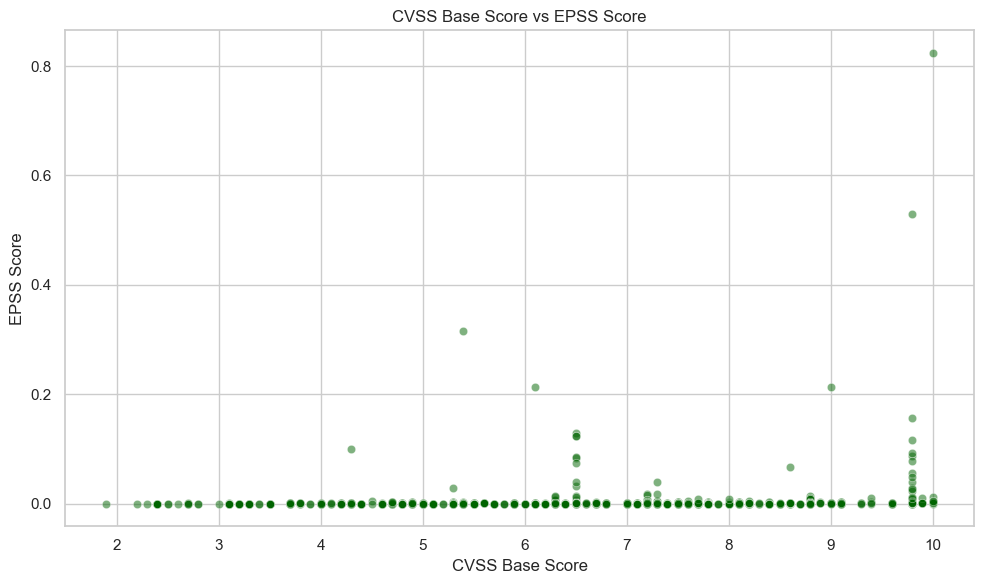

In [14]:
# Scatter plot: CVSS vs EPSS
# Scatter plot: CVSS vs EPSS
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='cvss_baseScore', y='epss', alpha=0.5, color='darkgreen')
plt.xlabel('CVSS Base Score')
plt.ylabel('EPSS Score')
plt.title('CVSS Base Score vs EPSS Score')
plt.tight_layout()
plt.show()

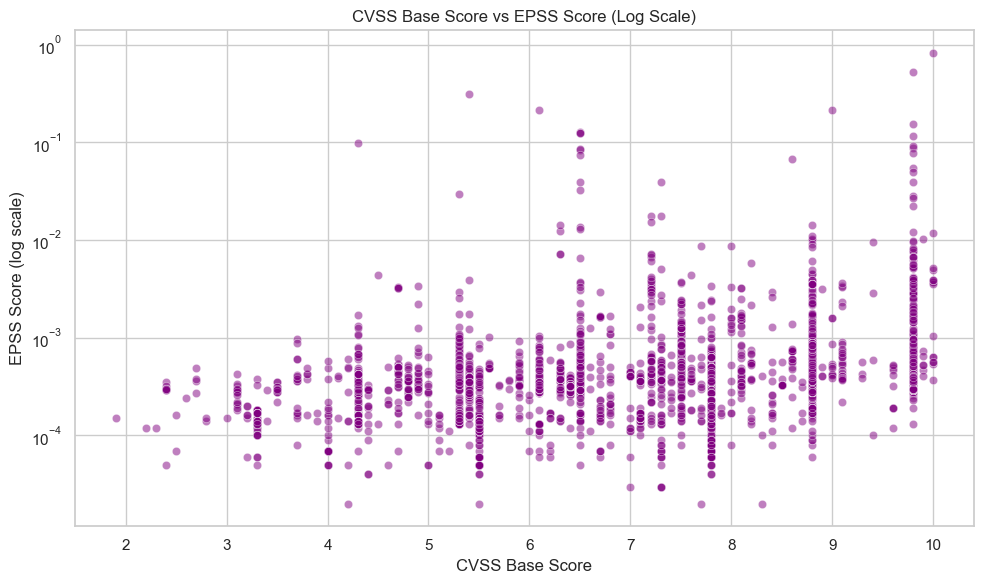

In [15]:
# Scatter plot with log scale for EPSS
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='cvss_baseScore', y='epss', alpha=0.5, color='purple')
plt.xlabel('CVSS Base Score')
plt.ylabel('EPSS Score (log scale)')
plt.yscale('log')
plt.title('CVSS Base Score vs EPSS Score (Log Scale)')
plt.tight_layout()
plt.show()


CVSS BASE SCORE - STATISTICS
count    3295.000000
mean        6.869772
std         1.805119
min         1.900000
25%         5.400000
50%         6.500000
75%         8.100000
max        10.000000
Name: cvss_baseScore, dtype: float64

Number of CVEs with CVSS score: 3295
Number of CVEs without CVSS score: 1032


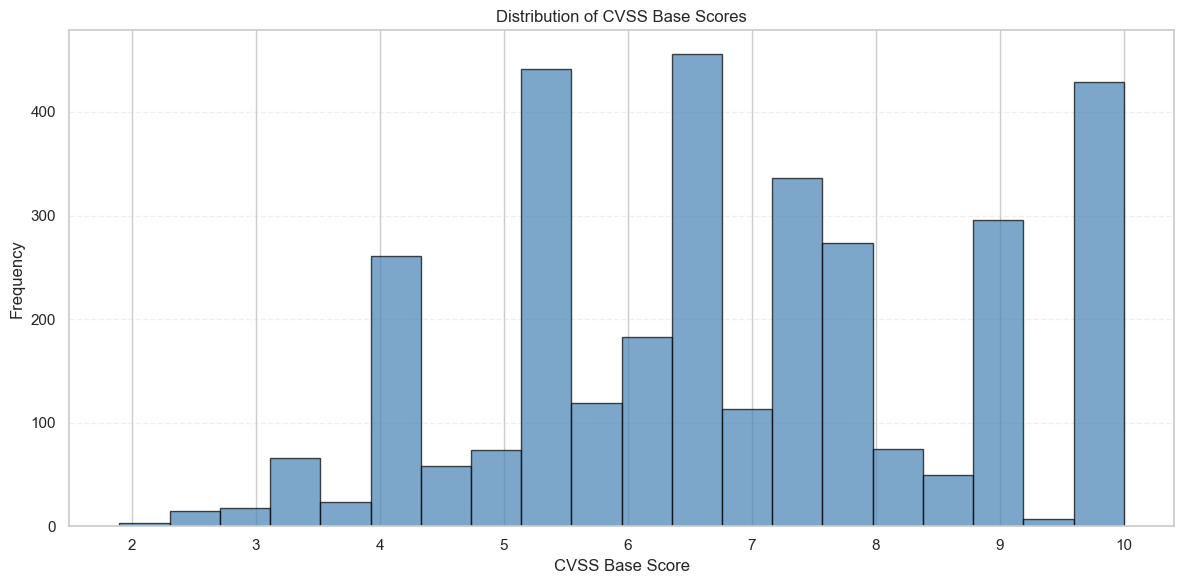

In [19]:
# CVSS Base Score - Descriptive Statistics and Distribution
print("CVSS BASE SCORE - STATISTICS")
cvss_stats = df['cvss_baseScore'].describe()
print(cvss_stats)
print(f"\nNumber of CVEs with CVSS score: {df['cvss_baseScore'].notna().sum()}")
print(f"Number of CVEs without CVSS score: {df['cvss_baseScore'].isna().sum()}")

# Distribution histogram
plt.figure(figsize=(12, 6))
df_with_cvss = df[df['cvss_baseScore'].notna()]

plt.hist(df_with_cvss['cvss_baseScore'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('CVSS Base Score')
plt.ylabel('Frequency')
plt.title('Distribution of CVSS Base Scores')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

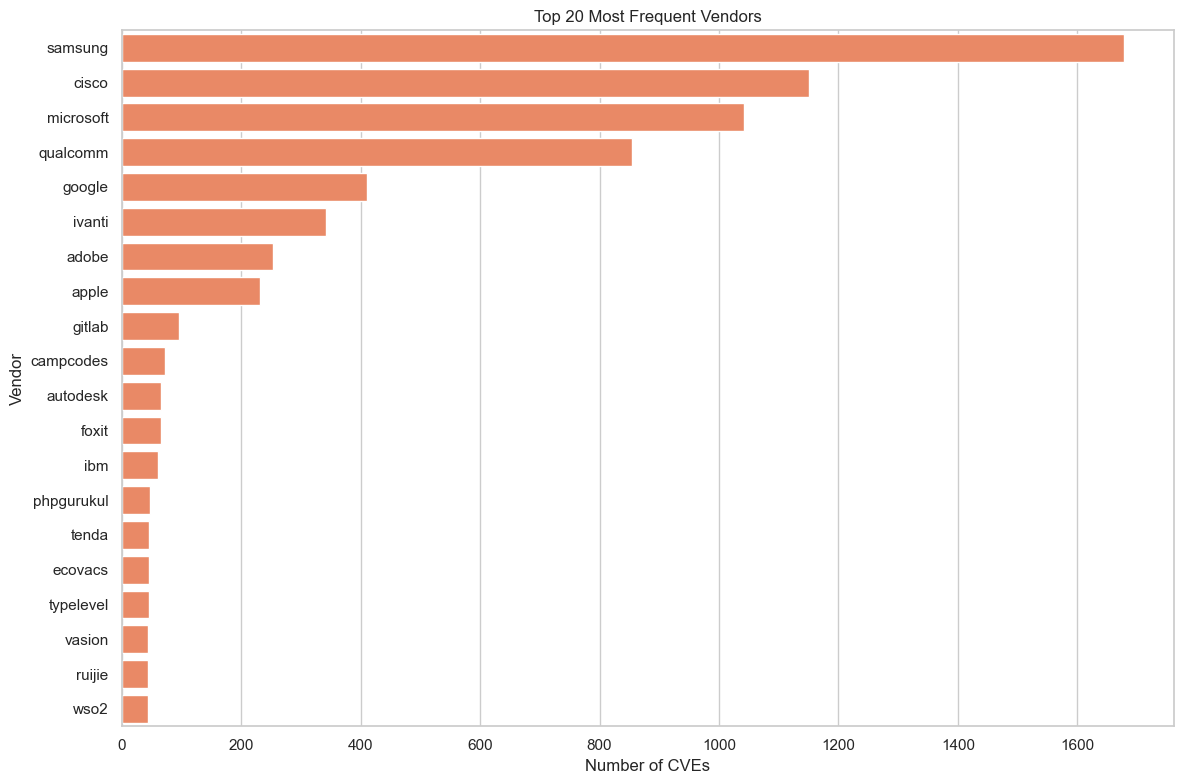


Top 20 Most Frequent Vendors:
    Vendor  Count
   samsung   1678
     cisco   1151
 microsoft   1041
  qualcomm    854
    google    411
    ivanti    341
     adobe    253
     apple    231
    gitlab     96
 campcodes     73
  autodesk     66
     foxit     65
       ibm     60
phpgurukul     47
     tenda     46
   ecovacs     45
 typelevel     45
    vasion     44
    ruijie     43
      wso2     43


In [23]:
# Extract vendors from CPE strings
# CPE format: cpe:2.3:a:vendor:product:version:...
import re
from collections import Counter

vendors = []
for cpes in df['vulnerable_cpes'].dropna():
    for cpe in cpes:
        # Extract vendor from CPE string (4th field after splitting by ':')
        parts = cpe.split(':')
        if len(parts) >= 4:
            vendor = parts[3]
            vendors.append(vendor)

# Count and get top 20
vendor_counts = Counter(vendors).most_common(20)

# Create DataFrame for visualization
vendor_df = pd.DataFrame(vendor_counts, columns=['Vendor', 'Count'])

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=vendor_df, x='Count', y='Vendor', color='coral')
plt.xlabel('Number of CVEs')
plt.ylabel('Vendor')
plt.title('Top 20 Most Frequent Vendors')
plt.tight_layout()
plt.show()

print(f"\nTop 20 Most Frequent Vendors:")
print(vendor_df.to_string(index=False))


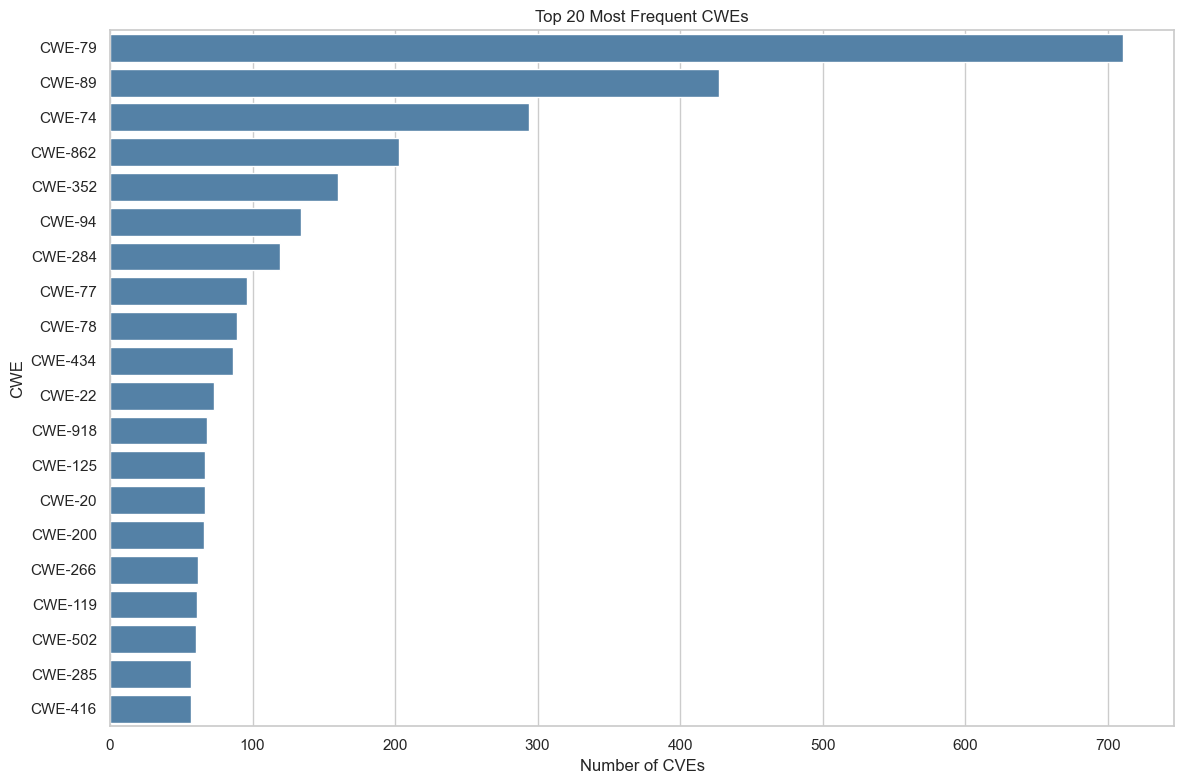


Top 20 Most Frequent CWEs:
    CWE  Count
 CWE-79    711
 CWE-89    427
 CWE-74    294
CWE-862    203
CWE-352    160
 CWE-94    134
CWE-284    119
 CWE-77     96
 CWE-78     89
CWE-434     86
 CWE-22     73
CWE-918     68
CWE-125     67
 CWE-20     67
CWE-200     66
CWE-266     62
CWE-119     61
CWE-502     60
CWE-285     57
CWE-416     57


In [24]:
# Extract CWEs from cwe_list
cwes = []
for cwe_list in df['cwe_list'].dropna():
    for cwe in cwe_list:
        cwes.append(cwe)

# Count and get top 20
cwe_counts = Counter(cwes).most_common(20)

# Create DataFrame for visualization
cwe_df = pd.DataFrame(cwe_counts, columns=['CWE', 'Count'])

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=cwe_df, x='Count', y='CWE', color='steelblue')
plt.xlabel('Number of CVEs')
plt.ylabel('CWE')
plt.title('Top 20 Most Frequent CWEs')
plt.tight_layout()
plt.show()

print(f"\nTop 20 Most Frequent CWEs:")
print(cwe_df.to_string(index=False))


In [30]:
nickname = 'template_submsission' # TODO: put your nickname here


# TODO: put your selected IDs here
selected = ['CVE-YYYY-XXXXX0',
            'CVE-YYYY-XXXXX1',
            'CVE-YYYY-XXXXX2',
            'CVE-YYYY-XXXXX3',
            'CVE-YYYY-XXXXX4',
            'CVE-YYYY-XXXXX5',
            'CVE-YYYY-XXXXX6',
            'CVE-YYYY-XXXXX7',
            'CVE-YYYY-XXXXX8',
            'CVE-YYYY-XXXXX9',
           ]            

df[df['cve.id'].isin(selected)].to_csv(os.path.join(data_path, f'{nickname}.csv'))            